In [9]:
import pickle

#load pickel file
with open('/scratch/hshang/moody/final_phase_submission/official-phase-mins-eth/images.pkl', 'rb') as f:
    data = pickle.load(f)
    

1.0075012647381373e-18 0.9999999701976776


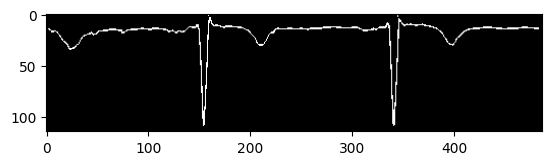

In [10]:
# print(data)
import matplotlib.pyplot as plt
import numpy as np

#plot the data
vis = np.where(data[3] > 0.1, 1, 0)
# plt.imshow(vis, cmap='gray')
plt.imshow(vis, cmap='gray')

print(min(data[1].flatten()), max(data[1].flatten()))

In [3]:
def compute_snr(x_ref, x_est, keep_nans=True, signal_median=False, noise_median=False):
    # Check the reference and estimated signals.
    x_ref = np.asarray(x_ref).copy()
    x_est = np.asarray(x_est).copy()
    assert(x_ref.ndim == x_est.ndim == 1)

    # Pad the shorter signal with NaNs so that both signals have the same length.
    n_ref = np.size(x_ref)
    n_est = np.size(x_est)
    if n_est < n_ref:
        x_est = np.concatenate((x_est, np.nan*np.ones(n_ref - n_est)))
    elif n_est > n_ref:
        x_ref = np.concatenate((x_ref, np.nan*np.ones(n_est - n_ref)))

    # Identify the samples with finite values, i.e., not NaN, +\infty, or -\infty.
    idx_ref = np.isfinite(x_ref)
    idx_est = np.isfinite(x_est) 

    # Either only consider samples with finite values in both signals (default) or replace the non-finite values in the estimated signal with zeros.
    if keep_nans:
        idx = np.logical_and(idx_ref, idx_est)
    else:
        x_est[~idx_est] = 0
        idx = idx_ref

    x_ref = x_ref[idx]
    x_est = x_est[idx]

    # Compute the noise.
    x_noise = x_ref - x_est

    # Compute the power for the signal and the noise using either the mean (default) or the median.
    if not signal_median:
        p_signal = np.mean(x_ref**2)
    else:
        p_signal = np.median(x_ref**2)

    if not noise_median:
        p_noise = np.mean(x_noise**2)
    else:
        p_noise = np.median(x_noise**2)

    # Compute the SNR.
    if p_signal > 0 and p_noise > 0:
        snr = 10 * np.log10(p_signal / p_noise)
    else:
        snr = float('nan')

    # If only considering the samples with finite values in both signals, then penalize the samples with non-finite values in the
    # estimated signal but not in the reference signal.
    if keep_nans:
        alpha = np.sum(idx) / np.sum(idx_ref)
        snr *= alpha

    return snr, p_signal, p_noise

In [29]:
from helper_code import *
import warnings

In [14]:
## helper functions
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

# def interpolate_nan(signal):
#     if np.isnan(signal[0]):
#         signal[0] = 0
#     if np.isnan(signal[-1]):
#         signal[-1] = 0
#     nans, x = nan_helper(signal)
#     if len(nans) == 0:
#         return signal
#     signal[nans] = np.interp(x(nans), x(~nans), signal[~nans])
#     return signal

from scipy.interpolate import CubicSpline

def interpolate_nan(signal):
    nans, x = np.isnan(signal), lambda z: z.nonzero()[0]
    if np.isnan(signal).all():
        warnings.warn("Signal is all nan", UserWarning)
        return np.zeros_like(signal)
    signal[nans] = np.interp(x(nans), x(~nans), signal[~nans])
    # For sharper interpolation:
    cs = CubicSpline(np.arange(len(signal)), signal, bc_type='natural')
    return cs(np.arange(len(signal)))

from scipy.signal import resample

def upsample(signal, target_length):
    return resample(signal, target_length)

def downsample(signal, target_length):
    return resample(signal, target_length)

def dist(tuple1, tuple2):
    return np.sqrt((tuple1[0]-tuple2[0])**2 + (tuple1[1]-tuple2[1])**2)

def group_bboxes_row(bboxes, vertical_distance_threshold):
    # bboxes_avg_H = list((bboxes[:,1]+bboxes[:,3])/2)
    # bboxes_avg_W = list((bboxes[:,0]+bboxes[:,2])/2)
    # bboxes_avg = bboxes[:,4:6]
    row_dict = {}
    for i in range(bboxes.shape[0]):
        h, w = bboxes[i,4:6]
    #for h, w  in bboxes_avg:
        if not bool(row_dict):
            row_dict[(h,w)] = [bboxes[i]]
        else:
            paired = False
            for key in row_dict.keys():
                if abs(key[0] - h) < vertical_distance_threshold:
                    row_dict[key].append(bboxes[i])
                    paired = True
                    break
            if not paired:
                row_dict[(h,w)] = [bboxes[i]]
    row_dict_new = {}
    row_dict_numcol = {}
    i = 0
    for key in row_dict.keys():
        row_dict_new[i]  = np.stack(row_dict[key], axis=0)
        row_dict_numcol[i] = len(row_dict[key])
        i += 1
    return row_dict_new, row_dict_numcol





def group_bboxes(bboxes, vertical_distance_threshold, horizontal_distance_threshold):
    bboxes_avg_H = list((bboxes[:,1]+bboxes[:,3])/2)
    bboxes_avg_W = list((bboxes[:,0]+bboxes[:,2])/2)
    bboxes_avg = np.array([bboxes_avg_H, bboxes_avg_W]).transpose()
    # sort by W
    row_dict = {}
    for h, w  in bboxes_avg:
        if not bool(row_dict):
            row_dict[(h,w)] = [(h, w)]
        else:
            paired = False
            for key in row_dict.keys():
                if abs(key[0] - h) < vertical_distance_threshold:
                    row_dict[key].append((h,w))
                    paired = True
                    break
            if not paired:
                row_dict[(h,w)] = [(h,w)]
    col_dict = {}
    for h, w in bboxes_avg:
        if not bool(col_dict):
            col_dict[(h,w)] = [(h, w)]
        else:
            paired = False
            for key in col_dict.keys():
                if abs(key[1] - w) < horizontal_distance_threshold:
                    col_dict[key].append((h,w))
                    paired = True
                    break
            if not paired:
                col_dict[(h,w)] = [(h,w)]
    return row_dict, col_dict


def filter_boxes(pred_bboxes, pred_labels, pred_scores, pred_masks):
    """
    Filter out the boxes with low confidence score and remove the boxes with high IoU
    Args:
        pred_bboxes (np): list of bounding boxes
        pred_labels (np): list of labels
        pred_scores (np): list of confidence scores
        pred_masks (np): list of maskss
    Returns:
        np: filtered bounding boxes
        np: filtered labels
        np: filtered confidence scores
        np: filtered masks
    """
    def bbox_intersection_over_smaller_area(box1, box2):
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1
        b2_x1, b2_y1, b2_x2, b2_y2 = box2

        # get the corrdinates of the intersection rectangle
        inter_rect_x1 = max(b1_x1, b2_x1)
        inter_rect_y1 = max(b1_y1, b2_y1)
        inter_rect_x2 = min(b1_x2, b2_x2)
        inter_rect_y2 = min(b1_y2, b2_y2)

        # Intersection area
        inter_area = max(inter_rect_x2 - inter_rect_x1 + 1, 0) * max(inter_rect_y2 - inter_rect_y1 + 1, 0)

        # boxes Area
        b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
        b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)
        
        return inter_area / min(b1_area, b2_area)
    def bbox_iou(box1, box2):
        """
        Calculate the Intersection of Unions (IoUs) between bounding boxes.
        Args:
            box1 (list): bounding box formatted as [x1, y1, x2, y2]
            box2 (list): bounding box formatted as [x1, y1, x2, y2]
        Returns:
            float: IoU value
        """
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1
        b2_x1, b2_y1, b2_x2, b2_y2 = box2

        # get the corrdinates of the intersection rectangle
        inter_rect_x1 = max(b1_x1, b2_x1)
        inter_rect_y1 = max(b1_y1, b2_y1)
        inter_rect_x2 = min(b1_x2, b2_x2)
        inter_rect_y2 = min(b1_y2, b2_y2)

        # Intersection area
        inter_area = max(inter_rect_x2 - inter_rect_x1 + 1, 0) * max(inter_rect_y2 - inter_rect_y1 + 1, 0)

        # Union Area
        b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
        b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

        iou = inter_area / (b1_area + b2_area - inter_area)

        return iou
    # # loop over bounding boxes, if find some boxes have iou > 0.5, filter out the one with lower score


    for i in range(len(pred_bboxes)):
        for j in range(i+1, len(pred_bboxes)):
            iou = bbox_intersection_over_smaller_area(pred_bboxes[i], pred_bboxes[j])
            if iou > 0.3:
                if pred_scores[i] > pred_scores[j]:
                    pred_scores[j] = 0
                else:
                    pred_scores[i] = 0
    pred_bboxes = pred_bboxes[pred_scores > 0]
    pred_labels = pred_labels[pred_scores > 0]
    pred_masks = pred_masks[pred_scores > 0]
    pred_scores = pred_scores[pred_scores > 0]
    
    if len(pred_scores) > 13:
        # sort the scores and get the top 13
        indices = np.argsort(pred_scores)[::-1][:13]
        pred_bboxes = pred_bboxes[indices]
        pred_labels = pred_labels[indices]
        pred_masks = pred_masks[indices]
        pred_scores = pred_scores[indices]
    
    return pred_bboxes, pred_labels, pred_scores, pred_masks

from scipy.signal import savgol_filter

def apply_savgol_filter(signal):
    return savgol_filter(signal, window_length=5, polyorder=3)  # Adjust parameters as needed

def bboxes_sorting(bboxes, img_width): # input: bboxes output by maskrcnn
    # first sort by H
    bboxes_avg_H = (bboxes[:,1]+bboxes[:,3])/2
    bboxes_avg_W = (bboxes[:,0]+bboxes[:,2])/2
    bboxes = np.append(bboxes, bboxes_avg_H.reshape((-1,1)), axis=1)
    bboxes = np.append(bboxes, bboxes_avg_W.reshape((-1,1)), axis=1)
    sortH_idx = bboxes[:, 4].argsort()
    bboxes = bboxes[sortH_idx]

    row_dict, row_dict_numcol = group_bboxes_row(bboxes, vertical_distance_threshold = img_width/10)
    if len(row_dict) == 4:
        ncol = max(list(row_dict_numcol.values()))
        if ncol == 4:
            print('row=4, col=4')
            ## step 1, adjust the bboxes
            rowswith4cols = [k for k,v in row_dict_numcol.items() if int(v) == 4]           
            left = min([np.min(row_dict[row][:,0]) for row in rowswith4cols])
            right = max([np.max(row_dict[row][:,2]) for row in rowswith4cols])
            leadwidth = (right - left)/4
            leftmid = left + leadwidth
            mid = left + 2*leadwidth
            rightmid = left + 3*leadwidth
            for key in [0,1,2]:
                if row_dict_numcol[key] == 4:
                    row_dict[key] = row_dict[key][row_dict[key][:,5].argsort()]
                    row_dict[key][0,0] = left
                    row_dict[key][0,2] = leftmid
                    row_dict[key][1,0] = leftmid
                    row_dict[key][1,2] = mid
                    row_dict[key][2,0] = mid
                    row_dict[key][2,2] = rightmid
                    row_dict[key][3,0] = rightmid
                    row_dict[key][3,2] = right
                else:
                    new_bboxes = np.nan*np.ones((4,4))
                    for i in range(row_dict[key].shape[0]):
                        h, w = row_dict[key][i,4:6]
                        if w < leftmid:
                            new_bboxes[0] = [left, row_dict[key][i,1], leftmid, row_dict[key][i,3]]
                        elif w < mid:
                            new_bboxes[1] = [leftmid, row_dict[key][i,1], mid, row_dict[key][i,3]]
                        elif w < rightmid:
                            new_bboxes[2] = [mid, row_dict[key][i,1], rightmid, row_dict[key][i,3]]
                        else:
                            new_bboxes[3] = [rightmid, row_dict[key][i,1], right, row_dict[key][i,3]]
                    row_dict[key] = new_bboxes
                    
            row_dict[3][0,0] = row_dict[3][0,0] if row_dict[3][0,0] < left else left
            row_dict[3][0,2] = row_dict[3][0,2] if row_dict[3][0,2] > right else right
            bboxes = np.concatenate([row_dict[0][:,0:4], row_dict[1][:,0:4], row_dict[2][:,0:4], row_dict[3][:,0:4]], axis=0)
            standard_format = [0, 12, 8, 1, 5, 9, 2, 6, 10, 3, 7, 11]
            bboxes = bboxes[standard_format]
            return bboxes, 4
    if len(row_dict) == 3:
        ncol = max(list(row_dict_numcol.values()))
        if ncol == 4:
            print('row=3, col=4')
            rowswith4cols = [k for k,v in row_dict_numcol.items() if int(v) == 4]           
            left = min([np.min(row_dict[row][:,0]) for row in rowswith4cols])
            right = max([np.max(row_dict[row][:,2]) for row in rowswith4cols])
            leadwidth = (right - left)/4
            leftmid = left + leadwidth
            mid = left + 2*leadwidth
            rightmid = left + 3*leadwidth
            for key in [0,1,2]:
                if row_dict_numcol[key] == 4:
                    row_dict[key] = row_dict[key][row_dict[key][:,5].argsort()]
                    row_dict[key][0,0] = left
                    row_dict[key][0,2] = leftmid
                    row_dict[key][1,0] = leftmid
                    row_dict[key][1,2] = mid
                    row_dict[key][2,0] = mid
                    row_dict[key][2,2] = rightmid
                    row_dict[key][3,0] = rightmid
                    row_dict[key][3,2] = right
                else:
                    new_bboxes = np.nan*np.ones((4,4))
                    for i in range(row_dict[key].shape[0]):
                        h, w = row_dict[key][i,4:6]
                        if w < leftmid:
                            new_bboxes[0] = [left, row_dict[key][i,1], leftmid, row_dict[key][i,3]]
                        elif w < mid:
                            new_bboxes[1] = [leftmid, row_dict[key][i,1], mid, row_dict[key][i,3]]
                        elif w < rightmid:
                            new_bboxes[2] = [mid, row_dict[key][i,1], rightmid, row_dict[key][i,3]]
                        else:
                            new_bboxes[3] = [rightmid, row_dict[key][i,1], right, row_dict[key][i,3]]
                    # bottom_max = np.max(row_dict[key][:,4])
                    # top_min = np.min(row_dict[key][:,1])
                    # new_bboxes = np.array([[left, top_min, leftmid, bottom_max], [leftmid, top_min, mid, bottom_max], [mid, top_min, rightmid, bottom_max], [rightmid, top_min, right, bottom_max]])
                    # row_dict[key] = new_bboxes
            bboxes = np.concatenate([row_dict[0][:,0:4], row_dict[1][:,0:4], row_dict[2][:,0:4]], axis=0)
            standard_format = [0, 4, 8, 1, 5, 9, 2, 6, 10, 3, 7, 11]
            bboxes = bboxes[standard_format]
            return bboxes, 3
    return None, None



## helper functions end 

#format = [['I', 'aVR', 'V1', 'V4'], ['II', 'aVL', 'V2', 'V5'], ['III', 'aVF', 'V3', 'V6'], ['II']] # format is hardcoded for now
#format = ['I', 'aVR', 'V1', 'V4', 'II', 'aVL', 'V2', 'V5', 'III', 'aVF', 'V3', 'V6']
#fullmode = 'II'

def crop_from_bbox(bbox, mask, mV_pixel):
    bbox = bbox.astype(int)
    ecg_segment = mask[bbox[1]:bbox[3]+1, bbox[0]:bbox[2]+1]

    weighting_matrix = np.linspace((bbox[3] - bbox[1])*mV_pixel/2, -1*(bbox[3] - bbox[1])*mV_pixel/2, num=ecg_segment.shape[0]).reshape(-1, 1)
    weighted_ecg_segment = ecg_segment * weighting_matrix

    denominator = np.sum(ecg_segment, axis=0)
    numerator = np.sum(weighted_ecg_segment, axis=0)

    signal = np.full(denominator.shape, np.nan)
    valid_idx = denominator >= 1
    signal[valid_idx] = numerator[valid_idx] / denominator[valid_idx]
    # check if signal is all nan
    if np.isnan(signal).all():
        warnings.warn("Signal is all nan", UserWarning)

    return signal

# median method
# def crop_from_bbox(bbox, mask, mV_pixel):
#     bbox = bbox.astype(int)
#     ecg_segment = mask[bbox[1]:bbox[3]+1, bbox[0]:bbox[2]+1]

#     height = ecg_segment.shape[0]

#     a = -1*mV_pixel*height/(height-1)
#     b = mV_pixel*height/2
#     signal = [a*np.median(np.argwhere(ecg_segment[:,i]))+b if len(np.argwhere(ecg_segment[:,i]))>1 else np.nan  for i in range(ecg_segment.shape[1])]
#     signal = np.array(signal)
#     return signal


def readOut(num_samples, masks, nrows, bboxes, mV_pixel):
    
    if nrows == 4:
        signals_np = np.full((12, num_samples), np.nan)
        for i in range(12):
            signal = crop_from_bbox(bboxes[i], masks[i], mV_pixel)
            signal = interpolate_nan(signal) - np.mean(signal)
            signal = np.clip(signal, -2, 2)
            signallen = num_samples if i == 1 else num_samples // 4
            start_idx = (num_samples // 4) * (i // 3)
            end_idx = start_idx + signallen
            if len(signal) < 5:
                signal = np.zeros(signallen)
            signal = apply_savgol_filter(signal)
            signal = upsample(signal, signallen) if len(signal) < signallen else downsample(signal, signallen)

    
    elif nrows == 3:
        signals_np = np.full((12, num_samples), np.nan)
        for i in range(bboxes.shape[0]):
            signal = crop_from_bbox(bboxes[i], masks[i], mV_pixel)
            signal = interpolate_nan(signal) - np.mean(signal)
            signal = np.clip(signal, -2, 2)
            signallen = num_samples // 4
            # signal = apply_savgol_filter(signal)
            signal = upsample(signal, signallen) if len(signal) < signallen else downsample(signal, signallen)
            start_idx = (num_samples // 4) * (i // 3)
            end_idx = start_idx + signallen
            
    signals_np[i, start_idx:end_idx] = signal
    signals_np = np.clip(signals_np, -2, 2)
    return signals_np.T if signals_np.shape[1] > signals_np.shape[0] else signals_np

In [75]:
from helper_code import align_signals
# Set limits on how far the signal can be shifted, and the number of quantization levels when shifting the signals.
def shift_signals(signal_ref, signal_est, sampling_frequency, channels, no_shift=False):
    max_hz_shift = np.round(0.5*sampling_frequency)
    max_vt_shift = 1.0
    num_quant_levels = 2**8

    # Shift the digitied signals to better align with the reference signals.
    signal_ref_collection = list()
    signal_est_collection = list()
    for j, channel in enumerate(channels):
        signal_ref_collection.append(signal_ref[:, j])
        # Align the signals.
        if not no_shift:
            signal_shifted, shift_hz, shift_vt = align_signals(signal_ref[:, j], signal_est[:, j], num_quant_levels=num_quant_levels)
            if abs(shift_hz) <= max_hz_shift and abs(shift_vt) <= max_vt_shift:
                signal_est_collection.append(signal_shifted)
            else:
                signal_est_collection.append(signal_est[:, j])
        else:
            signal_est_collection.append(signal_est[:, j])

41250
../test_data/00010_hr
SNR for lead I: -3.6203211891078215
SNR for lead avr: -4.722427685727666
SNR for lead v1: -4.670089903280854
SNR for lead v4: -4.502045968250981
SNR for lead II: -4.998847447029485
SNR for lead avl: -2.1672253395221666
SNR for lead v2: -4.259729634005296
SNR for lead v5: -4.666523316290544
SNR for lead III: -3.554374894250556
SNR for lead avf: -4.533872522797639
SNR for lead v3: -4.021820729397416
SNR for lead v6: -4.865506959655679
SNR: -4.215232132443009


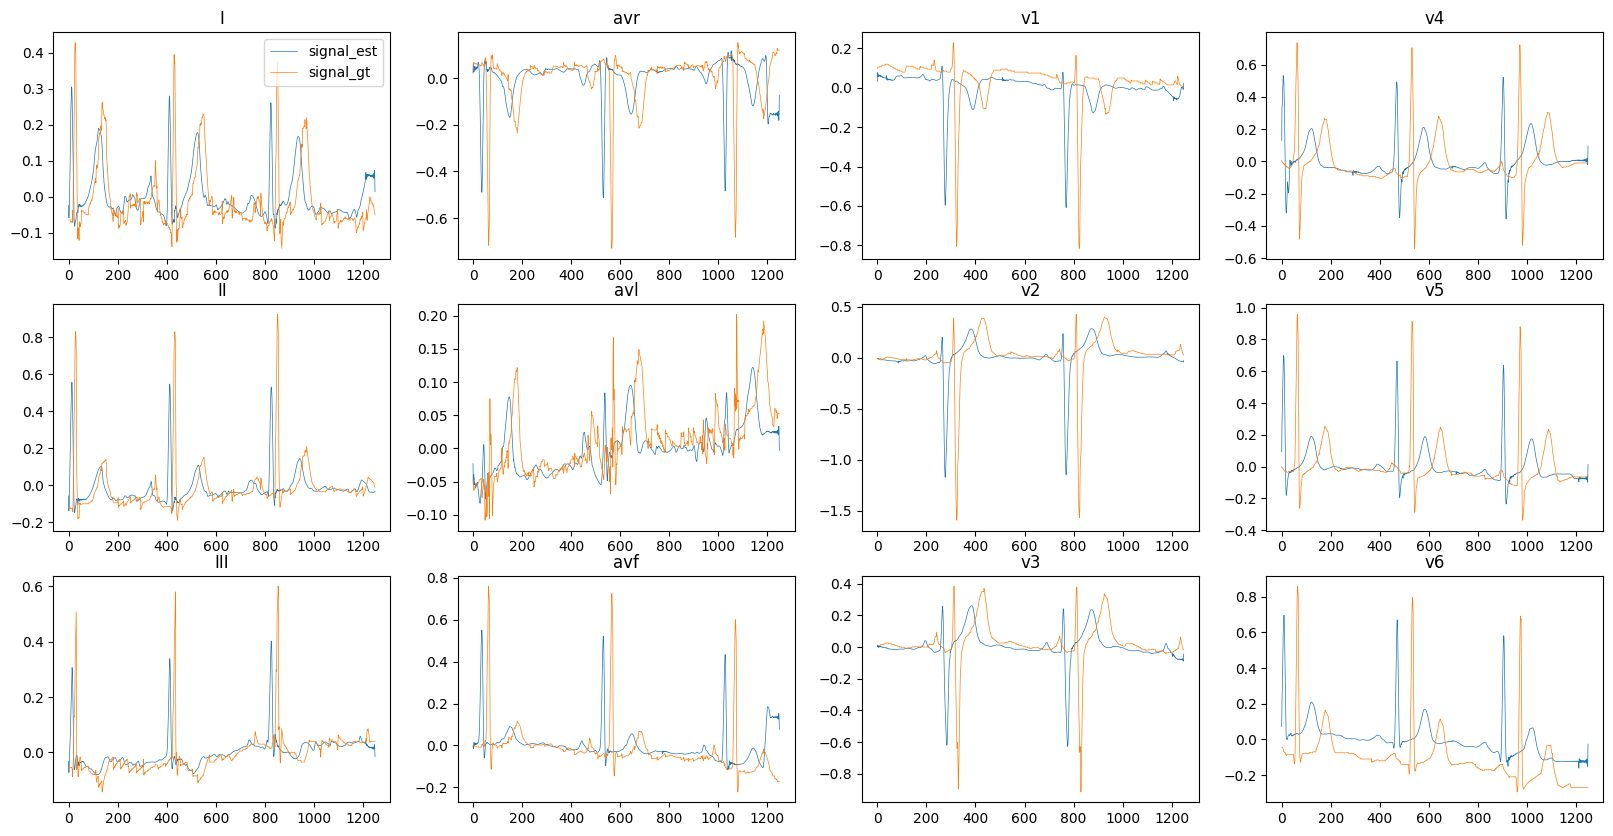

In [14]:
from helper_code import get_num_samples, load_signals, compute_snr
from scipy import interpolate
import numpy as np 
import warnings
import matplotlib.pyplot as plt
import pickle

    

# record = '/scratch/hshang/moody/final_phase_submission/test_data/00010_hr'
record='/scratch/hshang/moody/final_phase_submission/test_data/00010_hr'
pkl_pth = '/scratch/hshang/moody/final_phase_submission/official-phase-mins-eth/to_dump.pkl'
header_pth = record+'.hea'
with open(header_pth, 'r') as f:
    input_header = f.read()
num_samples = get_num_samples(input_header)

signal_gt = load_signals(record)[0]

pkl = pickle.load(open(pkl_pth, 'rb'))
masks = pkl['masks']#.detach().numpy()
bboxes = pkl['bboxes']#.detach().numpy()
scores = pkl['scores']#.detach().numpy()
labels = pkl['labels']#.detach().numpy()
record = pkl['record']
signal_est = pkl['signal_est']#.detach().numpy()
# print(signal_est.shape)
print(np.sum(np.where(np.isnan(signal_est), 1, 0)))
# signal_gt = load_signals(record)[0]
print(record)
# bboxes, labels, scores, masks = filter_boxes(bboxes, labels, scores, masks)
# plt.imshow(masks[0]*255, cmap='gray')
# print(np.sum(masks[0]))

import pywt
import numpy as np

def wavelet_denoising(signal, wavelet='db4', level=3):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    denoised_coeffs = [pywt.threshold(c, uthresh, mode='soft') for c in coeffs]
    return pywt.waverec(denoised_coeffs, wavelet)

# sigs = []
# # Example usage:
# for signal in signal_est:
#     filtered_signal = wavelet_denoising(np.drop)
#     sigs.append(filtered_signal)

# signal_est = np.array(sigs)

#format = ['I', 'aVR', 'V1', 'V4', 'II', 'aVL', 'V2', 'V5', 'III', 'aVF', 'V3', 'V6']
# mV_pixel = (25.4 *8.5*0.5)/(masks[0].shape[0]*5) 

# signal_est =readOut(num_samples, masks, 4, bboxes, mV_pixel)


# snr = compute_snr(signal_gt.flatten(), signal_est.flatten())
snrs = []
snr = compute_snr(signal_est[0:num_samples//4,0], signal_gt[0:num_samples//4,0])
snrs.append(snr[0])
print(f"SNR for lead I: {snr[0]}")

snr = compute_snr(signal_est[num_samples//4:(num_samples//4)*2,3], signal_gt[num_samples//4:(num_samples//4)*2,3])
snrs.append(snr[0])
print(f"SNR for lead avr: {snr[0]}")

snr = compute_snr(signal_est[(num_samples//4)*2:(num_samples//4)*3,6], signal_gt[(num_samples//4)*2:(num_samples//4)*3,6])
snrs.append(snr[0])
print(f"SNR for lead v1: {snr[0]}")

snr = compute_snr(signal_est[(num_samples//4)*3:num_samples,9], signal_gt[(num_samples//4)*3:num_samples,9])
snrs.append(snr[0])
print(f"SNR for lead v4: {snr[0]}")

snr = compute_snr(signal_est[0:num_samples//4,1], signal_gt[0:num_samples//4,1])
snrs.append(snr[0])
print(f"SNR for lead II: {snr[0]}")

snr = compute_snr(signal_est[num_samples//4:(num_samples//4)*2,4], signal_gt[num_samples//4:(num_samples//4)*2,4])
snrs.append(snr[0])
print(f"SNR for lead avl: {snr[0]}")

snr = compute_snr(signal_est[(num_samples//4)*2:(num_samples//4)*3,7], signal_gt[(num_samples//4)*2:(num_samples//4)*3,7])
snrs.append(snr[0])
print(f"SNR for lead v2: {snr[0]}")

snr = compute_snr(signal_est[(num_samples//4)*3:num_samples,10], signal_gt[(num_samples//4)*3:num_samples,10])
snrs.append(snr[0])
print(f"SNR for lead v5: {snr[0]}")

snr = compute_snr(signal_est[0:num_samples//4,2], signal_gt[0:num_samples//4,2])
snrs.append(snr[0])
print(f"SNR for lead III: {snr[0]}")

snr = compute_snr(signal_est[num_samples//4:(num_samples//4)*2,5], signal_gt[num_samples//4:(num_samples//4)*2,5])
snrs.append(snr[0])
print(f"SNR for lead avf: {snr[0]}")

snr = compute_snr(signal_est[(num_samples//4)*2:(num_samples//4)*3,8], signal_gt[(num_samples//4)*2:(num_samples//4)*3,8])
snrs.append(snr[0])
print(f"SNR for lead v3: {snr[0]}")

snr = compute_snr(signal_est[(num_samples//4)*3:num_samples,11], signal_gt[(num_samples//4)*3:num_samples,11])
snrs.append(snr[0])
print(f"SNR for lead v6: {snr[0]}")



print('SNR:', np.nanmean(snrs))
linewidth = 0.5
plt.figure(figsize=(20,10))
plt.subplot(3,4,1), plt.plot(signal_est[0:num_samples//4,0], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[0:num_samples//4,0], label='signal_gt',linewidth=linewidth), plt.title('I'), plt.legend()
plt.subplot(3,4,5), plt.plot(signal_est[0:num_samples//4,1], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[0:num_samples//4,1], label='signal_gt', linewidth=linewidth), plt.title('II')
plt.subplot(3,4,9), plt.plot(signal_est[0:num_samples//4,2], label = 'signal_est',linewidth=linewidth), plt.plot(signal_gt[0:num_samples//4,2], label='signal_gt',linewidth=linewidth), plt.title('III')

plt.subplot(3,4,2), plt.plot(signal_est[num_samples//4:(num_samples//4)*2,3], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[num_samples//4:(num_samples//4)*2,3], label='signal_gt', linewidth=linewidth), plt.title('avr')
plt.subplot(3,4,6), plt.plot(signal_est[num_samples//4:(num_samples//4)*2,4], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[num_samples//4:(num_samples//4)*2,4], label='signal_gt', linewidth=linewidth), plt.title('avl')
plt.subplot(3,4,10), plt.plot(signal_est[num_samples//4:(num_samples//4)*2,5], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[num_samples//4:(num_samples//4)*2,5], label='signal_gt', linewidth=linewidth), plt.title('avf')

plt.subplot(3,4,3), plt.plot(signal_est[(num_samples//4)*2:(num_samples//4)*3,6], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[(num_samples//4)*2:(num_samples//4)*3,6], label='signal_gt', linewidth=linewidth), plt.title('v1')
plt.subplot(3,4,7), plt.plot(signal_est[(num_samples//4)*2:(num_samples//4)*3,7], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[(num_samples//4)*2:(num_samples//4)*3,7], label='signal_gt', linewidth=linewidth), plt.title('v2')
plt.subplot(3,4,11), plt.plot(signal_est[(num_samples//4)*2:(num_samples//4)*3,8], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[(num_samples//4)*2:(num_samples//4)*3,8], label='signal_gt', linewidth=linewidth), plt.title('v3')


plt.subplot(3,4,4), plt.plot(signal_est[(num_samples//4)*3:num_samples,9], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[(num_samples//4)*3:num_samples,9], label='signal_gt', linewidth=linewidth), plt.title('v4')
plt.subplot(3,4,8), plt.plot(signal_est[(num_samples//4)*3:num_samples,10], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[(num_samples//4)*3:num_samples,10], label='signal_gt', linewidth=linewidth), plt.title('v5')
plt.subplot(3,4,12), plt.plot(signal_est[(num_samples//4)*3:num_samples,11], label = 'signal_est', linewidth=linewidth), plt.plot(signal_gt[(num_samples//4)*3:num_samples,11], label='signal_gt', linewidth=linewidth), plt.title('v6')

plt.show()
# plt.savefig('test.png')
plt.close()

Loads checkpoint by local backend from path: /scratch/hshang/moody/final_phase_submission/3x4_model/epoch_24.pth
12
12


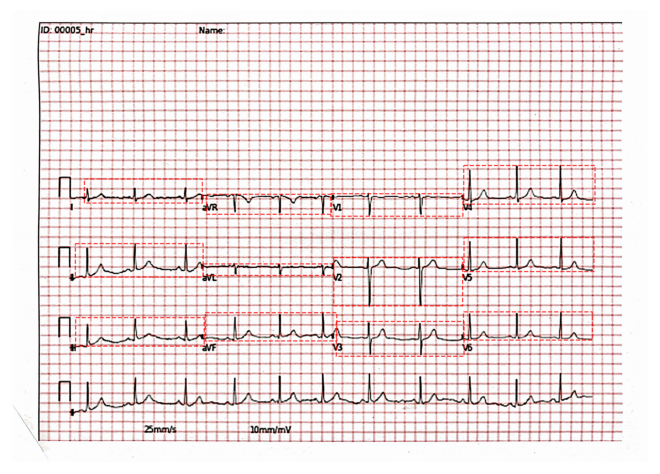

In [15]:

import mmcv
from mmdet.apis import init_detector, inference_detector
import os
import cv2
import numpy as np
# def remove_image_gradients(image_array):
#    # Step 2: Split the image into R, G, B channels
#     if image_array.shape[2] == 4:
#         b_channel, g_channel, r_channel, a_channel = cv2.split(image_array)
#     elif image_array.shape[2] == 3:
#         b_channel, g_channel, r_channel = cv2.split(image_array)
#         a_channel = np.ones_like(b_channel) * 255
#     else: return image_array

#     # Step 3: Apply Laplacian filter to each channel
#     laplacian_b = cv2.Laplacian(b_channel, cv2.CV_64F)
#     laplacian_g = cv2.Laplacian(g_channel, cv2.CV_64F)
#     laplacian_r = cv2.Laplacian(r_channel, cv2.CV_64F)

#     # Convert the result back to uint8 (8-bit image) because Laplacian can result in negative values
#     laplacian_b = cv2.convertScaleAbs(laplacian_b)
#     laplacian_g = cv2.convertScaleAbs(laplacian_g)
#     laplacian_r = cv2.convertScaleAbs(laplacian_r)

#     # Step 4: Merge the channels back together
#     laplacian_rgb = cv2.merge((laplacian_b, laplacian_g, laplacian_r))
#     return laplacian_rgb
# model_name = "mask_combo_loss_higher_res2"
model_name = "maskrcnn_res101"
# model_name = "deform_detr"
work_dir = f'/scratch/hshang/moody/final_phase_submission/model/'
# work_dir = f'TeamCode/src/configs_ckpts'
# config=os.path.join(work_dir, f'mask-rcnn_r50-caffe_fpn_ms-poly-3x_ecg.py')
config = os.path.join(work_dir, f'{model_name}.py')

# img_dir = '/scratch/hshang/moody/final_phase_submission/official-phase-mins-eth/TeamCode/tests/resources/test_scan'
# img_dir = os.path.join(img_dir, '00005_hr-0.png')
img_dir = '/scratch/hshang/moody/final_phase_submission/official-phase-mins-eth/TeamCode/tests/resources/test_scan/00005_hr-0.png'
# img_dir = '/scratch/hshang/moody/final_phase_submission/official-phase-mins-eth/TeamCode/tests/resources/test_data/00003_lr-0.png'
# img_dir = '/scratch/hshang/moody/final_phase_submission/test_data/00002_hr-0.png'
# img_dir = '/scratch/hshang/moody/final_training_set/processed_data/00006_hr-0.png'
img = mmcv.imread(img_dir,channel_order='rgb')
# checkpoint_file = '/scratch/hshang/moody/final_phase_submission/model/epoch_15.pth'
checkpoint_file = '/scratch/hshang/moody/final_phase_submission/3x4_model/epoch_24.pth'
# checkpoint_file = os.path.join(f'/scratch/hshang/moody/final_phase_submission/official-phase-mins-eth/TeamCode/src/configs_ckpts/', 'epoch_12.pth')
model = init_detector(config, checkpoint_file, device='cpu')
# processed_img = remove_image_gradients(img)
new_result = inference_detector(model, img)
# print(new_result)

from mmengine.visualization import Visualizer
import torch
import numpy as np
## extract boxes, masks, scores, and lables :
pred_bboxes = new_result.pred_instances.bboxes
pred_labels = new_result.pred_instances.labels
pred_scores = new_result.pred_instances.scores
print(len(pred_bboxes))
# pred_masks = new_result.pred_instances.masks
#check if pred_masks is all false
# print(np.all(pred_masks.cpu().numpy() == False))
pred_bboxes = pred_bboxes.cpu().numpy()
pred_labels = pred_labels.cpu().numpy()
pred_scores = pred_scores.cpu().numpy()
# pred_masks = pred_masks.cpu().numpy()
pred_masks = np.zeros((pred_bboxes.shape[0], img.shape[0], img.shape[1]))


def filter_boxes(pred_bboxes, pred_labels, pred_scores, pred_masks):
    """
    Filter out the boxes with low confidence score and remove the boxes with high IoU
    Args:
        pred_bboxes (np): list of bounding boxes
        pred_labels (np): list of labels
        pred_scores (np): list of confidence scores
        pred_masks (np): list of masks
    Returns:
        np: filtered bounding boxes
        np: filtered labels
        np: filtered confidence scores
        np: filtered masks
    """
    def bbox_intersection_over_smaller_area(box1, box2):
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1
        b2_x1, b2_y1, b2_x2, b2_y2 = box2

        # get the corrdinates of the intersection rectangle
        inter_rect_x1 = max(b1_x1, b2_x1)
        inter_rect_y1 = max(b1_y1, b2_y1)
        inter_rect_x2 = min(b1_x2, b2_x2)
        inter_rect_y2 = min(b1_y2, b2_y2)

        # Intersection area
        inter_area = max(inter_rect_x2 - inter_rect_x1 + 1, 0) * max(inter_rect_y2 - inter_rect_y1 + 1, 0)

        # boxes Area
        b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
        b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)
        
        return inter_area / min(b1_area, b2_area)
    def bbox_iou(box1, box2):
        """
        Calculate the Intersection of Unions (IoUs) between bounding boxes.
        Args:
            box1 (list): bounding box formatted as [x1, y1, x2, y2]
            box2 (list): bounding box formatted as [x1, y1, x2, y2]
        Returns:
            float: IoU value
        """
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1
        b2_x1, b2_y1, b2_x2, b2_y2 = box2

        # get the corrdinates of the intersection rectangle
        inter_rect_x1 = max(b1_x1, b2_x1)
        inter_rect_y1 = max(b1_y1, b2_y1)
        inter_rect_x2 = min(b1_x2, b2_x2)
        inter_rect_y2 = min(b1_y2, b2_y2)

        # Intersection area
        inter_area = max(inter_rect_x2 - inter_rect_x1 + 1, 0) * max(inter_rect_y2 - inter_rect_y1 + 1, 0)

        # Union Area
        b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
        b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

        iou = inter_area / (b1_area + b2_area - inter_area)

        return iou
    # # loop over bounding boxes, if find some boxes have iou > 0.5, filter out the one with lower score

    if len(pred_bboxes) > 13:
        for i in range(len(pred_bboxes)):
            for j in range(i+1, len(pred_bboxes)):
                iou = bbox_intersection_over_smaller_area(pred_bboxes[i], pred_bboxes[j])
                if iou > 0.3:
                    if pred_scores[i] > pred_scores[j]:
                        pred_scores[j] = 0
                    else:
                        pred_scores[i] = 0
        pred_bboxes = pred_bboxes[pred_scores > 0]
        pred_labels = pred_labels[pred_scores > 0]
        pred_masks = pred_masks[pred_scores > 0]
        pred_scores = pred_scores[pred_scores > 0]
    
    if len(pred_scores) > 13:
        # sort the scores and get the top 13
        indices = np.argsort(pred_scores)[::-1][:13]
        pred_bboxes = pred_bboxes[indices]
        pred_labels = pred_labels[indices]
        pred_masks = pred_masks[indices]
        pred_scores = pred_scores[indices]
    
    return pred_bboxes, pred_labels, pred_scores, pred_masks

filtered_bboxes, filtered_labels, filtered_scores, filtered_masks = filter_boxes(pred_bboxes, pred_labels, pred_scores, pred_masks)




# pred_image = mmcv.imread(img_dir, channel_order='rgb')
visualizer = Visualizer(image=img)

# draw multiple bboxes
# single bbox formatted as [xyxy]
print(len(filtered_bboxes))
visualizer.draw_bboxes(filtered_bboxes, edge_colors='r',
                       line_widths=3, line_styles = '--')

# visualizer.draw_texts(pred_scores.cpu().numpy(), pred_bboxes)
## to draw a box formatted as [xyxy]
# visualizer.draw_bboxes(torch.tensor([[33, 120, 209, 220], [72, 13, 179, 147]]))

# visualizer.draw_binary_masks(new_result.pred_instances.masks) ## this also works
# visualizer.draw_binary_masks(filtered_masks, colors=(0, 0, 255), alphas=0.9)

visualizer.show()

In [15]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset
from mmseg.apis import MMSegInferencer
from mmengine import Registry
from mmseg.apis import init_model, inference_model
from mmseg.apis import show_result_pyplot
import mmengine
from mmengine.registry import RUNNERS
from mmengine.runner import Runner
from mmengine.config import Config, DictAction
classes = ('bg', 'signal')
palette = [[255,255,255], [0,0,0]]


# @DATASETS.register_module()
# class ECGDataset(BaseSegDataset):
#     METAINFO = dict(classes = classes, palette = palette)
#     def __init__(self, **kwargs):
#         super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

# split train/val set randomly
import os.path as osp
data_root = '/scratch/hshang/moody/train_set_hr'
split_dir = 'splits'
img_dir = 'cropped_img'
ann_dir = 'cropped_masks'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
# select first 4/5 as train set
    train_length = int(len(filename_list)*4/5)
    f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
# select last 1/5 as train set
    f.writelines(line + '\n' for line in filename_list[train_length:])
# from mmengine import Config
cfg = Config.fromfile('/scratch/hshang/moody/mmsegmentation_MINS/demo/deeplabv3_unet_s5-d16_ce-1.0-dice-3.0_64x64_40k_drive-ecg.py')

cfg.data_root = data_root

cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2



# Modify dataset type and path
cfg.dataset_type = 'ECGDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

cfg.test_dataloader = cfg.val_dataloader
cfg.load_from = '/scratch/hshang/moody/mmsegmentation_MINS/demo/deeplabv3_unet_s5-d16_ce-1.0-dice-3.0_64x64_40k_drive_20211210_201825-6bf0efd7.pth'
# from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

runner.train()

08/19 05:51:40 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.19 (default, Mar 20 2024, 19:58:24) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0,1,2,3: NVIDIA TITAN X (Pascal)
    CUDA_HOME: /usr
    NVCC: Cuda compilation tools, release 11.2, V11.2.152
    GCC: gcc (Debian 10.2.1-6) 10.2.1 20210110
    PyTorch: 1.12.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compu

/scratch_net/narigpu01/hshang/conda_envs/openmmlab/lib/python3.8/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


08/19 05:52:02 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
08/19 05:52:02 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/scratch/hshang/moody/mmsegmentation_MINS/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/scratch/hshang/moody/mmsegmentation_MINS/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


08/19 05:52:02 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
Loads checkpoint by local backend from path: /scratch/hshang/moody/mmsegmentation_MINS/demo/deeplabv3_unet_s5-d16_ce-1.0-dice-3.0_64x64_40k_drive_20211210_201825-6bf0efd7.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([2, 16, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 16, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([1]).
08/19 05:52:03 - mmengine - INFO - Load checkpoint from /scratch/hshang/moody/mmsegmentation_MINS/demo/deeplabv3_unet_s5-d16_ce-1.0-dice-3.0_64x64_40k_drive_20211210_201825-6bf0efd7.pth
08/19 05:52:03 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-i

KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/scratch_net/narigpu01/hshang/conda_envs/openmmlab/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/scratch_net/narigpu01/hshang/conda_envs/openmmlab/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/scratch_net/narigpu01/hshang/conda_envs/openmmlab/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/scratch_net/narigpu01/hshang/conda_envs/openmmlab/lib/python3.8/site-packages/mmengine/dataset/base_dataset.py", line 410, in __getitem__
    data = self.prepare_data(idx)
  File "/scratch_net/narigpu01/hshang/conda_envs/openmmlab/lib/python3.8/site-packages/mmengine/dataset/base_dataset.py", line 793, in prepare_data
    return self.pipeline(data_info)
  File "/scratch_net/narigpu01/hshang/conda_envs/openmmlab/lib/python3.8/site-packages/mmengine/dataset/base_dataset.py", line 60, in __call__
    data = t(data)
  File "/scratch_net/narigpu01/hshang/conda_envs/openmmlab/lib/python3.8/site-packages/mmcv/transforms/base.py", line 12, in __call__
    return self.transform(results)
  File "/scratch/hshang/moody/mmsegmentation_MINS/mmseg/datasets/transforms/transforms.py", line 69, in transform
    img = results['img']
KeyError: 'img'


In [11]:
# split train/val set randomly
split_dir = 'splits'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [ ]:
from implementation import 

In [38]:
print(np.sum(masks[0]))

1160
